* logistic regression은 0에서 1사이의 y값을 가진다.
* 그렇기에 TF, 혹은 복수의 다항 분류(Classifier)에 활용된다.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf

tf.random.set_seed(100) # seed값 고정
print(tf.__version__)

2.0.0-alpha0


* 로지스틱 회귀분석을 하기 위해 테스트를 해보자
* x_train은 1행 2열의 훈련 데이터고
* y_train은 그 x_train의 결과인 0, 1의 binary 값이다.

In [2]:
x_train = [   # 분류를 하자면
    [1., 2.], # 일 떼, 0
    [2., 3.], # 일 때, 0
    [3., 1.], # 일 때, 0
    [4., 3.], # 일 때, 1
    [5., 3.], # 일 때, 1
    [6., 2.]  # 일 때, 1
]

y_train = [
    [0.],
    [0.],
    [0.],
    [1.],
    [1.],
    [1.]
]

* 이 친구들을 그래프에 그려보면

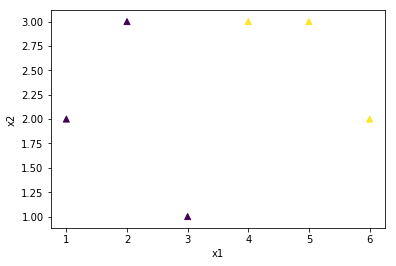

In [9]:
x1 = [x[0] for x in x_train] # x의 1행을 나타냄
x2 = [x[1] for x in x_train] # x의 2행을 나타냄

colors = [int(y[0] % 2) for y in y_train] # y_train에서 값을 꺼내서 y에 넣고 그 값을 3으로 나눈 것
plt.scatter(x1,x2, c=colors , marker='^') # x1, x2로 점을 찍고 marker를 삽입하고

plt.xlabel("x1") # 이름 넣기
plt.ylabel("x2") # 여기도 이름 넣기
plt.show()

* 이렇게 잘 구분된 데이터에 test값을 넣어보면 어떨까?
* 빨간색으로 test 데이터를 넣어보자

In [15]:
x_test = [[5.,2.]]
y_test = [[1.]]

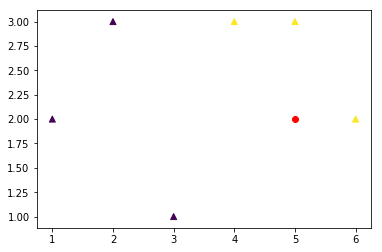

In [16]:
plt.scatter(x1,x2, c=colors , marker='^')
plt.scatter(x_test[0][0],x_test[0][1], c="red")

* 과연 logistic regression을 통해서 저 test값을 분류하면
* 보라색으로 나올까, 노란색으로 나올까?
* 그게 앞으로 우리가 해야할 일이다.

* 먼저 우리가 다룰 데이터를 구성한다.

In [17]:
dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(len(x_train)) # batch는 한 번에 학습시킬 사이즈를 파악하는 것

In [20]:
# 먼저 데이터 형태부터 짜자

W = tf.Variable(tf.zeros([2,1]), name='weight') # 행렬 연산을 위해 1행2열 형태의 데이터를 2행1열로 바꾸고 shape을 잡음
b = tf.Variable(tf.zeros([1]), name='bias')     # bias는 1개

* y가 0에서 1사이인 함수를 만들어서 예상치못한 상황에서도 범위 내에서 활동하도록 스케일링을 하자
* 그러기 위해 가장 좋은 함수의 형태가 아래의 sigmoid 함수다.
>
* x값이 무한히 커지면, e^(-x)는 0이 되고 분모는 1이 된다. 고로 sigmoid(x)는 1이 된다.
* 반대로 x값이 무한히 작아지면, e^(-x)는 무한대가 된다. 고로 sigmoid(x)는 0이 된다.
>
* 결과값을 0과 1로 구분해서 알 수 있다는 점에서 sigmoid는 분류 모델에 많이 쓰인다.


$$
\begin{align}
sigmoid(x) & = \frac{1}{1+e^{-x}}  \\\\\
\end{align}
$$

In [19]:
def logistic_regression(features):
    hypothesis = tf.divide(1., 1.+tf.exp(tf.matmul(features, W) + b))
    return hypothesis

* 그런데 이 hypothesis를 그대로 cost function 가져다 쓰면 상당히 불편하다.
<img width="500" src="https://t1.daumcdn.net/cfile/tistory/245FCB48579821A913">


* 오른쪽 그림처럼 울퉁불퉁하기에 cost function을 구할 때
* local mininum을 cost의 최소값으로 인식하고 마무리할 수도 있기 때문이다.
* 그래서 Cost function의 모양을 바꿔준다.

### 새로운 Cost function
>
>
$$
\begin{align}
cost(h(x),y) & = −log(h(x))  &  if  &  y=1 \\\\\
cost(h(x),y) & = -log(1−h(x))  &  if  &  y=0
\end{align}
$$

* 수식을 정리하면 아래와 같이 한 줄의 식으로 정리가 가능하다.
$$
\begin{align}
cost(h(x),y) & = −y log(h(x))−(1−y)log(1−h(x))
\end{align}
$$

In [40]:
def loss_fn(hypothesis, features, labels): #features는 X, labels는 Y
    cost = tf.reduce_mean(-labels * tf.math.log(logistic_regression(features)) - (1- labels) * tf.math.log(1 - logistic_regression(features))) # logistic_regression(features) = hypothesis 다.
    return cost

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01) # learning_rate의 적절한 값 설정

In [41]:
# 위를 통해 나온 결과값이 0.5를 기준으로 넘으면 1, 넘지 못하면 0이 되도록 분류하자

def accuracy_fn(hypothesis, labels):
    predicted = tf.cast(hypothesis > 0.5, dtype = tf.float32) # 0.5를 넘으면 1, 못 넘으면 0으로 설정하고
    accuracy = tf.reduce_mean(tf.cast(tf.equal(predicted, labels), dtype = tf.int32)) # predicted(예측값)과 labels(실제값)이 같으면 1, 아니면 0으로 다시 정확도 판단해서 평균내기
    return accuracy

In [42]:
# 한 번만 끝낼 게 아니라 for문 돌려서 계속 써야 하니까
# GradientTape으로 경사값 계산

def grad(hypothesis, features, labels):
    with tf.GradientTape() as tape:
        loss_value = loss_fn(logistic_regression(features), features, labels) # cost 함수
    return tape.gradient(loss_value, [W, b]) # loss_value, 즉 cost 함수의 W, b값의 미분값을 찾기

In [43]:
# 이제 for문을 돌리자(학습 실행)

EPOCHS = 1001

for step in range(EPOCHS):
    for features, labels in iter(dataset):
        grads = grad(logistic_regression(features), features, labels)
        optimizer.apply_gradients(grads_and_vars = zip(grads, [W, b]))
        
        if step % 100 == 0: #100단위로 값 프린트
            print("Iter: {}, Loss: {:.4f}".format(step, loss_fn(logistic_regression(features),features,labels)))

Iter: 0, Loss: 0.6213
Iter: 100, Loss: 0.5628
Iter: 200, Loss: 0.5249
Iter: 300, Loss: 0.4982
Iter: 400, Loss: 0.4784
Iter: 500, Loss: 0.4628
Iter: 600, Loss: 0.4499
Iter: 700, Loss: 0.4388
Iter: 800, Loss: 0.4291
Iter: 900, Loss: 0.4202
Iter: 1000, Loss: 0.4120
